# Umbrella Sampling
 
 
## Introduction
 
Umbrella sampling is a technique used in molecular dynamics simulations to improve sampling in systems containing high barriers in the free energy landscape. With plain MD simulations the system can remain trapped in free energy minima whereas umbrella sampling adds extra biasing potentials to drive the system in the direction of a chosen collective variable (CV). This enables the calculation of free energy profiles much more efficiently than is possible with regular MD alone.
 
## Theory
This section explains more of the details behind umbrella sampling. Refer to [[1](#References), [2](#References)] for full information. The text in this section is from [[3](#References)].
 
The free energy of a system in the canonical ensemble is
 
$F=-k_B T \text{log}(Z),$
 
where $Z$ is the canonical partition function. For all but the smallest systems $Z$ is computationally intractable to calculate. However, often the most interesting information about a molecular system is given by the differences in the free energy across system states. A Collective Variable (CV; also called a reaction coordinate) can be defined which is a continuous variable that distinguishes different states. The simplest types of CVs are geometric distances (e.g. the distance between two molecules) but there are many other possibilities. The CV $x$ is a function of the atomic coordinates, $x(r)$, and multiple different realizations of $r$ can map to the same $x$. The probability distribution of the system can be written in terms of $x$:
 
$p(x) \propto \int{ e^{-\beta E(r)} \delta (x-x(r))dr},$
 
where we have integrated the Boltzmann distribution over all degrees of freedom for each value of $x$. The probability can be turned into a free energy:
 
$F(x) = -k_B T \text{log} (p(x)) + C,$
 
where $C$ is a constant and unimportant as we are only interested in $∆F$. In theory, the free energy profile along $x$ could be computed by sampling the system in equilibrium and recording the probability histogram of the values of $x$ which occur. However, for any non-trivial potential energy surface it will take a very long time to achieve sufficient sampling to get an adequately converged histogram — the high energy states will not be sampled.
 
To enhance the sampling umbrella sampling can be used. This adds additional biasing potentials $w(x)$ to the system to restrain it at certain values of $x$. The form of $w$ is usually a harmonic term:
 
$w(x) = \frac{1}{2} k (x-x_0)^2,$
 
where $k$ is a constant with units of energy per units of $x$ squared. We then run multiple simulations, each restrained with a different $w$, and then combine them to generate a probability distribution that sufficiently samples the whole range of $x$. The process is illustrated in figure 1 and explained in more detail as follows.



![umbrella_sampling](umbrella_sampling.svg)

**Figure 1. Umbrella sampling method to compute a free energy profile.** (a) Multiple biasing potentials are placed across the collective variable $x$. The blue curve is the free energy of the system which we are trying to calculate. (b) Simulations are run for each window $w$. The resulting biased probability distributions $P'(x)$ are plotted. (c) The unbiased free energies $F_i$ from each window. They are each offset by a different $C_i$. (d) The Weighted Histogram Analysis Method (WHAM) is used to combine the windows and compute the free energy curve.



With a biasing potential $w(x(r))$ the potential energy of the system becomes
 
$E'(r) = E(r) + w((x(r)))$
 
which leads to a probability distribution (in the canonical ensemble) of
 
$p'(x) \propto \int e^{-\beta (E + w)} \delta (x - x(r)) dr \propto p(x) e^{-\beta w(x)},$
 
and a free energy of
 
$F'(x) = -k_B T \text{log}(p(x)) + w(x) + C = F(x) + w(x) + C.$
 
Thus, the unbiased free energy $F$ can be obtained by subtracting the biasing potential $w$ from the biased free energy $F'$. However, when more than one biasing window is used the value of $C$ cannot be neglected as it will be different for each window. For multiple biasing windows we have a set of unbiased (but offset by different $C_i$) free energies,
 
$F_i(x) = -k_B T \text{log}(p'_i) + w_i + C_i.$
 
To compute $F$ over the full range of $x$ the different $F_i(x)$ need to be combined. This can be accomplished by the Weighted Histogram Analysis Method (WHAM) [[1](#References)]. The WHAM equations are shown in [appendix section 2](#WHAM-equations). The free energy profile is also called the Potential of Mean Force (PMF); in this example we will assume they are equivalent and use them interchangeably.
 
## Umbrella sampling simulations
 
Most umbrella sampling simulations have three main steps:
 
1. Preparing the windows. This is usually done using Steered Molecular Dynamics (SMD; see [appendix section 1](#Steered-MD)). 
2. Running the windows. These can be computed in parallel to take advantage of compute resources.
3. Analysing the results. Typically this involves computing a PMF with WHAM. 
 
Often you will find in step 3 that the simulations do not produce a nicely converged PMF. You will need to return to step 1 and change some settings. This trial and improvement feedback loop is a normal part of the process. For this tutorial we will use settings already known to work.
 
## System
 
This tutorial will use umbrella sampling to compute the free energy profile of the end-to-end distance ($r$) of deca-alanine in vacuum. Deca-alanine is commonly used as a toy system [[4](#References)]. Its equilibrium structure is a stable alpha-helix. Starting with the alpha-helix structure we will first perform a SMD simulation to pull it from a helix into a coil. Next, we will run 24 umbrella sampling windows in the range 1.3nm to 3.3nm. Finally, we will compute the PMF along $r$. Figure 2 shows the initial alpha-helix structure and the final extended coil structure.

![deca-alanine](deca-alanine.png)

**Figure 2** Structure of deca-alanine for end-to-end distance $r$=1.3 and $r$=3.3nm.
 
## Step 1 - Setting up the windows with SMD
 
The script below does the following steps:
-   Loads in a PDB file.
-   Defines a collective variable between the first and last alpha-carbon.
-   Adds a harmonic restraint to the CV.
-   Runs a simulation where the location of the harmonic restraint is moved with constant velocity from 1.3nm to 3.3nm (This is called constant velocity steered MD).
-   Saves a configuration for each of the 24 equally spaced windows between 1.3nm and 3.3nm.


In [1]:
import openmm as mm
import openmm.app as app
import openmm.unit as unit
from sys import stdout
import numpy as np

pdb = app.PDBFile('deca-ala.pdb')

forcefield = app.ForceField('amber14-all.xml')

# We have a single molecule in vacuum so we use no cutoff.
system = forcefield.createSystem(pdb.topology, nonbondedMethod=app.NoCutoff, constraints=app.HBonds, hydrogenMass=1.5*unit.amu)
integrator = mm.LangevinMiddleIntegrator(300*unit.kelvin, 1/unit.picosecond, 0.004*unit.picoseconds)
simulation = app.Simulation(pdb.topology, system, integrator)
simulation.context.setPositions(pdb.positions)
simulation.reporters.append(app.DCDReporter('smd_traj.dcd', 10000))
simulation.reporters.append(app.StateDataReporter(stdout, 10000, step=True, time=True, potentialEnergy=True, temperature=True, speed=True))

# equilibrate
simulation.context.setVelocitiesToTemperature(300*unit.kelvin)
simulation.step(1000)

# define the CV as the distance between the CAs of the two end residues
index1 = 8
index2 = 98
cv = mm.CustomBondForce('r')
cv.addBond(index1, index2)

# now setup SMD

# starting value
r0 = 1.3*unit.nanometers

# force constant
fc_pull = 1000.0*unit.kilojoules_per_mole/unit.nanometers**2 

# pulling speed
v_pulling = 0.02*unit.nanometers/unit.picosecond # nm/ps

# simulation time step
dt = simulation.integrator.getStepSize()

# total number of steps
total_steps = 30000 # 120ps

# number of steps to run between incrementing r0 (1 makes the simulation slow)
increment_steps = 10

# define a harmonic restraint on the CV
# the location of the restrain will be moved as we run the simulation
# this is constant velocity steered MD
pullingForce = mm.CustomCVForce('0.5 * fc_pull * (cv-r0)^2')
pullingForce.addGlobalParameter('fc_pull', fc_pull)
pullingForce.addGlobalParameter('r0', r0)
pullingForce.addCollectiveVariable("cv", cv)
system.addForce(pullingForce)
simulation.context.reinitialize(preserveState=True)

# define the windows
# during the pulling loop we will save specific configurations corresponding to the windows
windows = np.linspace(1.3, 3.3, 24)
window_coords = []
window_index = 0

# SMD pulling loop
for i in range(total_steps//increment_steps):
    simulation.step(increment_steps)
    current_cv_value = pullingForce.getCollectiveVariableValues(simulation.context)
    
    if (i*increment_steps)%5000 == 0:
        print("r0 = ", r0, "r = ", current_cv_value)
    
    # increment the location of the CV based on the pulling velocity
    r0 += v_pulling * dt * increment_steps
    simulation.context.setParameter('r0',r0)

    # check if we should save this config as a window starting structure
    if (window_index < len(windows) and current_cv_value >= windows[window_index]):
        window_coords.append(simulation.context.getState(getPositions=True, enforcePeriodicBox=False).getPositions())
        window_index += 1

# save the window structures
for i, coords in enumerate(window_coords):
    outfile = open(f'window_{i}.pdb', 'w')
    app.PDBFile.writeFile(simulation.topology,coords, outfile)
    outfile.close()

r0 =  1.3 nm r =  (1.4174937009811401,)
r0 =  1.699999999999956 nm r =  (1.6807529926300049,)
#"Step","Time (ps)","Potential Energy (kJ/mole)","Temperature (K)","Speed (ns/day)"
10000,39.99999999999959,263.2258952076669,337.49615573701277,0
r0 =  2.099999999999912 nm r =  (1.935304045677185,)
r0 =  2.499999999999868 nm r =  (2.297661542892456,)
20000,80.00000000000584,411.4646992187624,298.8327209938384,686
r0 =  2.899999999999824 nm r =  (2.7887115478515625,)
r0 =  3.29999999999978 nm r =  (3.217346668243408,)
30000,120.00000000005473,500.88444719701704,338.0651512398154,678


Once the script has completed running there will be 24 new pdb files called "window_n.pdb" where n is an integer from 0 to 23.
 
We now have the initial configurations for the umbrella sampling windows.
 
## Step 2 - Running the windows
 
The script to run the windows is very similar to the script in step 1. The key differences are that we load in an initial structure that corresponds to each specific window and that the harmonic restraint on the CV does not move. The script below defines a function to run one window. It re-uses the `Simulation` we created in step 1.

In [2]:
def run_window(window_index):

    print('running window', window_index)
    
    # load in the starting configuration for this window
    pdb = app.PDBFile(f'window_{window_index}.pdb')

    # we can reuse the existing Simulation
    simulation.context.setPositions(pdb.positions)

    # set the fixed location of the harmonic restraint for this window
    r0 = windows[window_index]
    simulation.context.setParameter('r0', r0)

    # run short equilibration with new positions and r0
    simulation.context.setVelocitiesToTemperature(300*unit.kelvin)
    simulation.step(1000)

    # run the data collection

    # total number of steps
    total_steps = 100000 # 400 ps

    # frequency to record the current CV value
    record_steps = 1000

    # run the simulation and record the value of the CV.
    cv_values=[]
    for i in range(total_steps//record_steps):
        simulation.step(record_steps)

        # get the current value of the cv
        current_cv_value = pullingForce.getCollectiveVariableValues(simulation.context)
        cv_values.append([i, current_cv_value[0]])

    # save the CV timeseries to a file so we can postprocess 
    np.savetxt(f'cv_values_window_{window_index}.txt', np.array(cv_values))

    print('Completed window', window_index)

We then run all 24 windows

In [3]:
for n in range(24):
    run_window(n)

running window 0
40000,159.9999999999899,178.77566228771775,281.41486145487505,726
50000,199.9999999998967,236.80864074429337,284.6546934786752,764
60000,239.99999999980346,207.6091096836783,336.4385758838052,794
70000,279.99999999988074,192.72364813422865,314.56361335295367,814
80000,320.00000000007174,224.07179699482003,308.0634055757345,830
90000,360.00000000026273,226.51138636596897,300.175650350942,841
100000,400.0000000004537,209.02971457283206,264.37204988231275,852
110000,440.0000000006447,213.05129946541666,309.2321522737234,859
120000,480.0000000008357,192.63949342426804,272.1676431824938,866
130000,520.0000000010267,222.33414315907362,313.7896087160025,868
Completed window 0
running window 1
140000,560.0000000012177,249.79379517516034,327.3820328149076,849
150000,600.0000000014087,261.58829256314135,282.95587378888945,816
160000,640.0000000015997,219.67048654402774,271.73778969564665,823
170000,680.0000000017907,177.47826222915367,287.7443000659337,829
180000,720.00000000198

Once all the window simulations have completed you will have the CV timeseries files: "cv_values_window_n.txt"

## Step 3 - Analysis - compute the PMF

The first thing to check is that the histograms of the CV timeseries have good overlap. Here is an example:
![histogram](hist.png)


You can plot yours with the script below
(This script also produces the metadata file we will need for the next step).

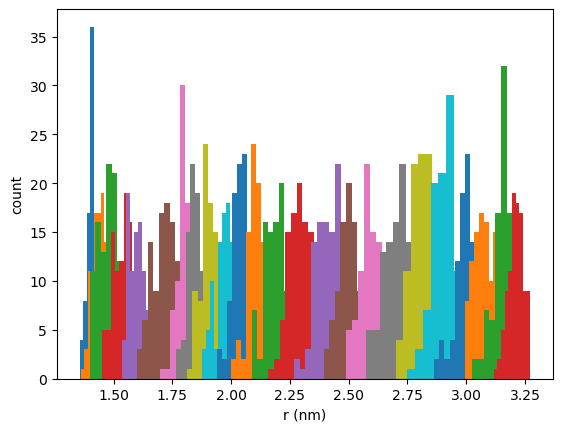

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# plot the histograms
metafilelines = []
for i in range(len(windows)):
    data = np.loadtxt(f'cv_values_window_{i}.txt')
    plt.hist(data[:,1])
    metafileline = f'cv_values_window_{i}.txt {windows[i]} 1000\n'
    metafilelines.append(metafileline)

plt.xlabel("r (nm)")
plt.ylabel("count")

with open("metafile.txt", "w") as f:
    f.writelines(metafilelines)

To compute the PMF we can use WHAM [[1](#References)]. An easy to use and widely compatible implementation is the WHAM program by Alan Grossfield which can be downloaded here: http://membrane.urmc.rochester.edu/?page_id=126. It is a C program so it will need to be compiled. The command below should work on Linux and Mac.

In [5]:
!wget http://membrane.urmc.rochester.edu/sites/default/files/wham/wham-release-2.0.11.tgz
!tar xf wham-release-2.0.11.tgz
!cd wham/wham && make

--2023-05-18 16:32:56--  http://membrane.urmc.rochester.edu/sites/default/files/wham/wham-release-2.0.11.tgz
Resolving membrane.urmc.rochester.edu (membrane.urmc.rochester.edu)... 128.151.10.151
Connecting to membrane.urmc.rochester.edu (membrane.urmc.rochester.edu)|128.151.10.151|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 327680 (320K) [application/x-gzip]
Saving to: ‘wham-release-2.0.11.tgz.3’

wham-release-2.0.11 100%[===================>] 320.00K   660KB/s    in 0.5s    

2023-05-18 16:32:57 (660 KB/s) - ‘wham-release-2.0.11.tgz.3’ saved [327680/327680]

make: Nothing to be done for `all'.


To use `wham` we need a metadata file that lists the names of each CV timeseries file, the location of the harmonic restraints, and the value of the spring constant. We created this in the histogram plotting script earlier.
 
The `wham` program is run using command line arguments. Read the documentation to find out more: http://membrane.urmc.rochester.edu/sites/default/files/wham/doc.pdf
 
The command below will compute the PMF from our data. The command line arguments correspond to a range of 1.3nm to 3.3nm, 50 histogram bins, a tolerance of 1e-6, and a temperature of 300K.


In [6]:
!./wham/wham/wham 1.3 3.3 50 1e-6 300 0 metafile.txt pmf.txt > wham_log.txt

We can then plot the computed PMF. It should look something like this:
![pmf.png](pmf.png)

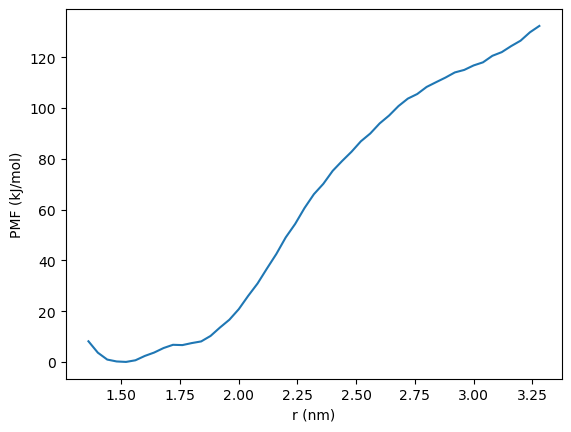

In [7]:
# plot the PMF
pmf = np.loadtxt("pmf.txt")
plt.plot(pmf[:,0], pmf[:,1])
plt.xlabel("r (nm)")
plt.ylabel("PMF (kJ/mol)")
plt.show()

## Next steps

You should now perform error analysis to confirm the PMF you have calculated is an accurate representation of the system you are simulating. Here are a few suggestions:

- Run some completely independent repeats and check the computed PMFs are the same.
- Perform the initial steered MD loop at a slower speed. If this step is too fast your windows will have initial states that are far from equilibrium.
- Run the windows for longer. If you have sampled enough then with longer runtime the calculated PMF should be the same. If the PMF is different it means your initial simulations were not long enough. Increase the runtime until the calculated PMFs are the same.
- Similarly, using more windows you should get the same results.

Other tips:

- If the histograms have poor overlap you will need to use more windows and/or reduce the spring constant.
- The windows do not need to be linearly spaced and they can have different spring constants.
 

## References

[1] Kumar, S., Rosenberg, J.M., Bouzida, D., Swendsen, R.H. and Kollman, P.A. (1992), *The weighted histogram analysis method for free-energy calculations on biomolecules. I. The method.* J. Comput. Chem., 13: 1011-1021. https://doi.org/10.1002/jcc.540130812  
[2] Kästner, J. (2011), *Umbrella sampling.* WIREs Comput Mol Sci, 1: 932-942. https://doi.org/10.1002/wcms.66  
[3] Farr, S. (2021), https://doi.org/10.17863/CAM.72078  
[4] Park, S., Khalili-Araghi, F., Tajkhorshid, E., and Schulten, K. (2003), *Free energy calculation from steered molecular dynamics simulations using Jarzynski’s equality.* J. Chem. Phys., 119 (6): 3559–3566. https://doi.org/10.1063/1.1590311  

## Appendix
 
### Steered MD
 
Steered MD is a non-equilibrium method which means great care must be taken to ensure the results you get are meaningful. In this tutorial steered MD is just used in the setup phase and we do not calculate any properties with it.
In constant velocity steered MD the biasing potential has the form
 
$w = \frac{1}{2} k (x-x_0(t))^2,
x_0(t) = x_0(0)+vt,$
 
which is just a moving version of the umbrella window bias potential.
 
### WHAM equations
The WHAM equations [1] are:
 
$P(x_j) = \frac{\sum^{N_w}_i h_i(x_j)}{\sum^{N_w}_i n_i e^ {\beta(C_i - w_i(x_j))} },$
 
$C_i = -k_B T \log\left( \sum_j P(x_j) e^{-\beta w_i(x_j)} \right).$
 
Where they have been written in a fully discretized form. $P(x_j)$ is the resulting unbiased probability distribution where $j$ is the index for the discrete set of $x_j$ that $P$ is computed over. $N_w$ is the number of windows, $i$ is the index of each window, $n_i$ is the number of data points (realizations of $x$) in the $i$-th window trajectory, $h_i(x_j)$ is the number of points in histogram bin $j$ from trajectory $i$, and  $w_i$ are the biasing potentials. Both equations depend on each other so must be solved self-consistently. In practice this is solved iteratively: initial guesses of $C_i$ are chosen, $P$ is then calculated using the first equation, new values of $C_i$ are then calculated using the second equation, and the process is iterated until the differences between successive values are sufficiently small.
 

